In [60]:
import numpy as np
from scipy.optimize import curve_fit, least_squares
import matplotlib.pyplot as plt
import sncosmo
import pandas as pd
from astropy.table import Table
import math
from lmfit.models import SkewedGaussianModel


/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Formula for magnitude from flux:

$$m=zp-2.5log_{10}(f)$$

Where $zp$ is the zero point, $f$ the flux and $m$ the magnitude.

Consequently, the formula for flux from magnitude is:

$$\boxed{f = 10^{\frac{-m+zp}{2.5}}}$$

Now, we can calculate $\sigma_{f}$ based on $\sigma_{m}$ using error propagation:

$$\sigma_f = \sqrt{\left(\frac{\delta g}{\delta m}\right)^2 \cdot \sigma_m^2}$$

Where $g(m)$ is the formula for calculating the flux from magnitude. Thus, we have that:

$$\frac{\delta g}{\delta m} = \frac{-ln(10)\cdot10^{\frac{-m+zp}{2.5}}}{2.5}$$

As a result, we have that:

$$\boxed{\sigma_f = \sqrt{\left(\frac{-ln(10)\cdot10^{\frac{-m+zp}{2.5}}}{2.5}\right)^2\cdot\sigma_m^2}}$$


In [2]:
zp = 24.80

In [3]:
def fluxFromMag(m):
    return 10**((-m+zp)/2.5)

def sigmaF(m,sigmaM):
    dgdm = (np.log(10)*10**((zp-m)/2.5)/2.5)
    return (dgdm**2*sigmaM**2)**0.5

def chi2salt2(lc,model):
#     model = sncosmo.Model(source='salt2')
    res, fitted_model = sncosmo.fit_lc(lc, model, ['z', 't0', 'x0', 'x1', 'c'],  bounds={'z':(0.1, 1.3)})
    return res.chisq
    

In [4]:
transients = pd.read_pickle('../DiegoData/lightCurves/transient_lightcurves_clean.pickle')
non_transients = pd.read_pickle('../DiegoData/lightCurves/nontransient_lightcurves_clean.pickle')
catalogue = pd.read_pickle('../DiegoData/transient_catalog.pickle')

In [5]:
# Rename columns to match light curves
catalogue = catalogue.rename(
    columns={'TransientID': 'ID', 'Classification': 'class'})
catalogue.ID = 'TranID' + catalogue.ID.apply(str)
catalogue = catalogue.set_index('ID')

In [6]:
transients = transients.join(catalogue, how='inner')

In [7]:
non_transients['class'] = 'non-transient'

In [8]:
all_objects = transients.append(non_transients)


In [9]:
all_objects['zp'] = zp 
all_objects['zpsys'] = 'ab'
all_objects['band'] = "sdssr"

allCols = list(all_objects.columns)
allCols[2] = 'time'
all_objects.columns = allCols

In [10]:
all_objects['flux'] = fluxFromMag(all_objects['Mag'])
all_objects['fluxerr'] = sigmaF(all_objects['Mag'],all_objects['Magerr'])
all_objects = all_objects.drop(['Mag','Magerr'],axis=1)

In [11]:
SN  = all_objects[all_objects['class'] == 'SN']
NSN = all_objects[all_objects['class'] != 'SN']

In [47]:
def salt2Df(df):
    ids = df.index.get_level_values('ID').unique()
    ids = np.random.choice(ids,200,replace=False)
    dfToProcess = df[df.index.get_level_values('ID').isin(ids)]
    table = Table.from_pandas(dfToProcess.reset_index())
    
    obs_by_name = table.group_by('ID')
    chis = []
    cont = 1
    model = sncosmo.Model(source='salt2')
    for key, group in zip(obs_by_name.groups.keys, obs_by_name.groups):
    #     print(len(group))
        try:
            chis.append(chi2salt2(group,model))
        except:
            chis.append(-1)
        print('\r {} {} {} '.format(str(len(group)),str(cont*100/len(obs_by_name.groups)),cont),end='')
        cont += 1
        if(cont==200):
            return chis
    

In [48]:
chisSN = salt2Df(SN)

 8 4.0 8 

/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: invalid value encountered in multiply
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))


 21 13.5 27 

/home/mauro/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 4 99.5 199 

In [50]:
chisNSN = salt2Df(NSN)

 395 13.0 26 

/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: invalid value encountered in multiply
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/mauro/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 229 99.5 199 

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


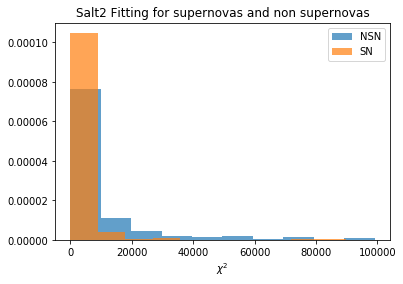

In [52]:
plt.hist(chisNSN,label='NSN',alpha = 0.7,normed = True)
plt.hist(chisSN,label='SN'  ,alpha = 0.7,normed = True)
plt.title('Salt2 Fitting for supernovas and non supernovas')
plt.xlabel(r'$\chi^2$')
plt.legend()

In [41]:
def mod_gauss(t, a, t0, tf, tr, b):
    return a*((np.exp(-(t-t0)/tf))/(1+np.exp(-(t-t0)/tr)))+b
def get_max_index(fluxes):
    max_val = 0
    max_index = -1
    for i, elem in enumerate(fluxes):
        
        if max_val<elem:
            max_val = elem
            max_index = i
            
    return max_index

In [42]:
def show_fit_mod_gaussians(t, colors, n_factor = None, plot=True, show_means=False):

    
    t_by_filter = t.group_by("bandpass")

    
    min_date = min(t["mjd"])
    max_date = max(t["mjd"])
    
     
    indices = t_by_filter.groups.indices
    
  
    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        x = data["mjd"]-min_date
        y = data["flux"]
        
        
        max_i = get_max_index(data["flux"])
        mean_date = data[max_i]["mjd"]-min_date
        
        
        n = len(x)
        sigma = np.std(y)
        
        
        popt, pcov = curve_fit(mod_gauss, x, y, p0=[data[max_i]["flux"], mean_date, 2, 1.5, 0], maxfev=500000,  sigma = data["flux_error"])
        
        
        c = (y - mod_gauss(x, *popt))
        chi = (y - mod_gauss(x, *popt))/data["flux_error"]
    
        chi2 = (chi**2).sum()
        dof = len(x) - len(popt)
        
        

   
    return popt, pcov, chi2, dof

In [109]:
def chiGaussian(table):
    min_date = min(table["time"])
    max_date = max(table["time"])
    
    data=table
    
    x = data["time"]-min_date
    y = data["flux"]


    max_i = get_max_index(data["flux"])
    mean_date = data[max_i]["time"]-min_date


    n = len(x)
    sigma = np.std(y)


#     popt, pcov = curve_fit(mod_gauss, x, y, p0=[data[max_i]["flux"], mean_date, 2, 1.5, 0], maxfev=500000,  sigma = data["fluxerr"])


#     c = (y - mod_gauss(x, *popt))
#     chi = (y - mod_gauss(x, *popt))/data["fluxerr"]

#     chi2 = (chi**2).sum()
    
#     dof = len(x) - len(popt)
#     print('Y:',list(y))
#     print('modGauss: ',list(mod_gauss(x, *popt)))
    
#     print("Chi:" ,list(chi))
#     print('-'[0]*50)
#     return chi2

    
    model = SkewedGaussianModel()

    # set initial parameter values
    params = model.make_params(amplitude=max(y), center=mean_date, sigma=sigma, gamma=1)

    # adjust parameters  to best fit data.
    result = model.fit(y, params, x=x)
#     print('laksdlaks')
    return result.chisqr
#     print(result.fit_report())
    
def chiGaussianAll(df):
#     print('entra')
    ids = df.index.get_level_values('ID').unique()
    ids = np.random.choice(ids,200,replace=False)
    dfToProcess = df[df.index.get_level_values('ID').isin(ids)]
    table = Table.from_pandas(dfToProcess.reset_index())
#     print(table.columns)
    obs_by_name = table.group_by('ID')
    chis = []
    cont = 1
    for key, group in zip(obs_by_name.groups.keys, obs_by_name.groups):
        try:
            chis.append(chiGaussian(group))
            cont += 1
        except:
            chis.append(-1)
#         break
        print('\r {} {} {} '.format(str(len(group)),str(cont*100/len(obs_by_name.groups)),cont),end='')
        
        if(cont==200):
            return chis
    
    return chis

In [110]:
chisSNGaussian = chiGaussianAll(SN)

 7 87.0 174 

In [112]:
chisNSNGaussian = chiGaussianAll(NSN)

 5 92.5 185 

In [113]:
print(len(chisSNGaussian))
print(len(chisNSNGaussian))

200
200


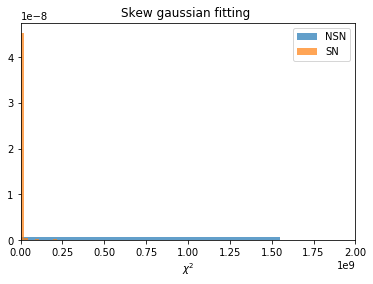

In [132]:
plt.hist(chisNSNGaussian,label='NSN',alpha = 0.7,density=True)
plt.hist(chisSNGaussian,label='SN'  ,alpha = 0.7,density=True)
plt.title('Skew gaussian fitting ')
plt.xlabel(r'$\chi^2$')
plt.xlim(0,2e9)
plt.legend()